In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

import os
import sys
import pickle

sys.path.append("../scripts")
from utils import Utils
from clean_data import DataCleaner



In [2]:
cleaner = DataCleaner()
utility = Utils()

### User engagement and user experience score

In [3]:
cleaned_df=utility.load_data("../data/cleaned_data.csv")
user_engagement = utility.load_data("../data/user_engagement_metric.csv")
user_experience = utility.load_data("../data/user_experience_metrics.csv")

# since our csv file doesn't have a meta data of columns dtype, we manually convert ['bearer_id', 'imsi', 'msisdn/number', 'imei','handset_type'] to string once again
cleaned_df=cleaner.convert_to_string(cleaned_df)


In [4]:
user_engagement.head()

,msisdn/number,session_traffic(bytes),session_duration(ms),session_freq,cluster,score
0,3.197021e+12,232123971.0,325035.5,1.0,1,0.001210
1,3.360100e+10,878690574.0,116720.0,1.0,0,0.000058
2,3.360100e+10,156859643.0,181230.0,1.0,2,0.000965
3,3.360100e+10,595966483.0,134969.0,1.0,0,0.000036
4,3.360101e+10,422320698.0,49878.0,1.0,0,0.000073


In [5]:
user_experience.head()

,msisdn,handset_type,total_rtt(ms),total_tp(kbps),total_tcp(bytes),score
0,3.366496e+10,Samsung Galaxy A5 Sm-A520F,47.0,67.0,589679.5,0.472741
1,3.368185e+10,Samsung Galaxy J5 (Sm-J530),70.0,42.0,589679.5,0.472781
2,3.376063e+10,Samsung Galaxy A8 (2018),50.0,15.0,589679.5,0.472826
3,3.375034e+10,undefined,50.0,88.0,589679.5,0.472706
4,3.369980e+10,Samsung Sm-G390F,50.0,15.0,589679.5,0.472826


### Satisfaction score

In [6]:
user_engagement.rename(columns={"score": "engagement_score"}, inplace=True)
user_experience.rename(columns={"score": "experience_score"}, inplace=True)
user_engagement.rename(columns={"msisdn/number": "msisdn"}, inplace=True)

In [7]:
user_satisfaction_metrics = pd.merge(user_engagement, user_experience, on="msisdn")
user_satisfaction_metrics['satisfaction_score'] = user_satisfaction_metrics[['engagement_score','experience_score']].mean(axis=1)

In [8]:
score_df = user_satisfaction_metrics[['msisdn', 'satisfaction_score','engagement_score', 'experience_score']]

In [9]:
score_df['msisdn'] = score_df['msisdn'].astype(str)
score_df = cleaner.remove_nan_categorical(score_df)

C:\Users\Natnael\AppData\Local\Temp\ipykernel_17580\3782924676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['msisdn'] = score_df['msisdn'].astype(str)


In [10]:
score_df.dropna(inplace=True)

### top 10 satisfied customers

In [11]:
top_10_satisfied = score_df.sort_values(by=['satisfaction_score'], ascending=False).head(10)
top_10_satisfied

,msisdn,satisfaction_score,engagement_score,experience_score
58703,33661003893.0,0.594846,0.000140,1.189552
130914,33761066497.0,0.588357,0.000131,1.176583
111821,33683692867.0,0.578779,0.000124,1.157435
119107,33698551167.0,0.528437,0.000018,1.056856
110578,33681782404.0,0.513988,0.000139,1.027836
79551,33664704919.0,0.513952,0.000117,1.027786
31456,33650128412.0,0.513551,0.000077,1.027026
135161,33762062356.0,0.513241,0.000126,1.026357
131121,33761124811.0,0.513052,0.000215,1.025889
108959,33679366089.0,0.512706,0.000028,1.025384


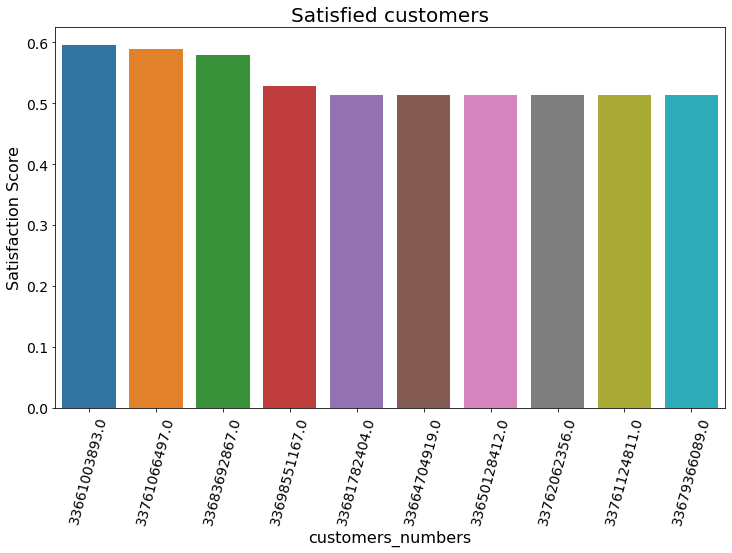

In [12]:
utility.plot_bar(df=top_10_satisfied[['msisdn','satisfaction_score']],title="Satisfied customers",x_col="msisdn",y_col="satisfaction_score",xlabel="customers_numbers",ylabel="Satisfaction Score")

the difference can't be clearly seen from the bar graph so it is better to visualize it with line graph

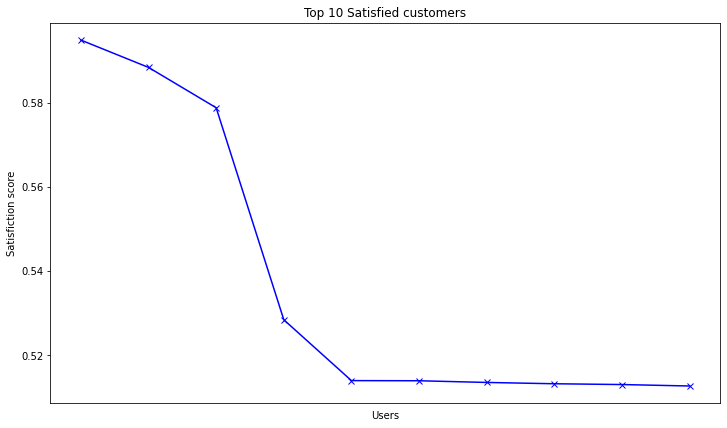

In [13]:
plt.figure(figsize=(12, 7))
plt.plot(top_10_satisfied['msisdn'],top_10_satisfied['satisfaction_score'],'bx-')
plt.xlabel('Users') 
plt.xticks(ticks=[''])
plt.ylabel('Satisfiction score') 
plt.title('Top 10 Satisfied customers')
plt.show()


### Modeling (Regression Model)

In [14]:
col_rearrange=['msisdn','handset_type','session_traffic(bytes)','session_duration(ms)','session_freq','engagement_score','total_rtt(ms)','total_tp(kbps)','total_tcp(bytes)','experience_score','satisfaction_score']
user_satisfaction_metrics_rearranged=user_satisfaction_metrics[col_rearrange]

In [15]:
user_satisfaction_metrics_rearranged.corr()

,msisdn,session_traffic(bytes),session_duration(ms),session_freq,engagement_score,total_rtt(ms),total_tp(kbps),total_tcp(bytes),experience_score,satisfaction_score
msisdn,1.000000,-0.004000,0.004798,-0.002766,0.019684,-0.000381,-0.001879,-0.000243,0.000823,0.000873
session_traffic(bytes),-0.004000,1.000000,0.588105,0.813259,-0.438212,-0.025085,0.142989,0.022887,-0.027747,-0.028862
session_duration(ms),0.004798,0.588105,1.000000,0.725577,-0.009490,-0.060421,0.020027,0.015398,0.040991,0.040962
session_freq,-0.002766,0.813259,0.725577,1.000000,-0.258920,-0.027437,0.178255,0.029475,-0.034764,-0.035420
engagement_score,0.019684,-0.438212,-0.009490,-0.258920,1.000000,-0.012409,-0.116324,-0.015675,0.044073,0.046619
total_rtt(ms),-0.000381,-0.025085,-0.060421,-0.027437,-0.012409,1.000000,0.001298,0.008199,0.019610,0.019576
total_tp(kbps),-0.001879,0.142989,0.020027,0.178255,-0.116324,0.001298,1.000000,0.132948,-0.139806,-0.140086
total_tcp(bytes),-0.000243,0.022887,0.015398,0.029475,-0.015675,0.008199,0.132948,1.000000,0.017945,0.017903
experience_score,0.000823,-0.027747,0.040991,-0.034764,0.044073,0.019610,-0.139806,0.017945,1.000000,0.999997
satisfaction_score,0.000873,-0.028862,0.040962,-0.035420,0.046619,0.019576,-0.140086,0.017903,0.999997,1.000000


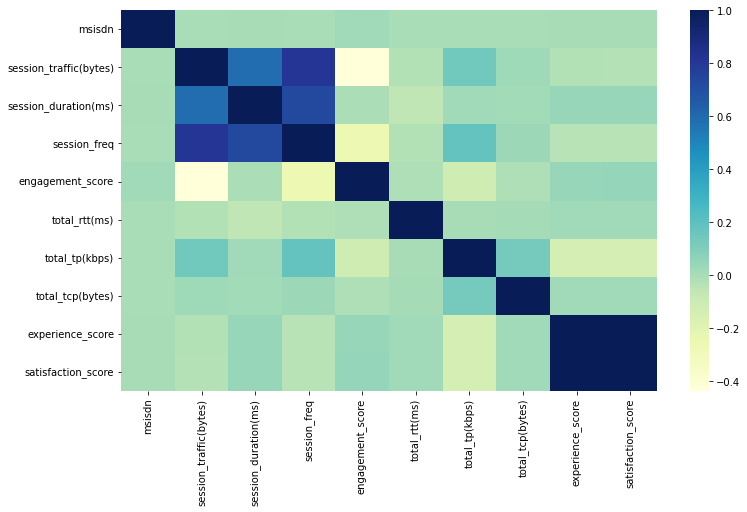

In [16]:
plt.figure(figsize=(12, 7))
sns.heatmap(user_satisfaction_metrics_rearranged.corr(),cmap="YlGnBu")
plt.show()

from the above heatmap we can see that total_rtt is less correlated with other features and msisdn, obviously is the least correlated with the others <br>
handset types was not included in the correlation because it is categorical column we shall apply label encoding

Apply label encoding for handset_types

In [17]:
le = LabelEncoder()
label_encoded_satisfaction_metrics = user_satisfaction_metrics_rearranged.copy()
for col in label_encoded_satisfaction_metrics.select_dtypes(include='O').columns:
    label_encoded_satisfaction_metrics[col]=le.fit_transform(label_encoded_satisfaction_metrics[col])

In [18]:
label_encoded_satisfaction_metrics.corr()

,msisdn,handset_type,session_traffic(bytes),session_duration(ms),session_freq,engagement_score,total_rtt(ms),total_tp(kbps),total_tcp(bytes),experience_score,satisfaction_score
msisdn,1.000000,0.001534,-0.004000,0.004798,-0.002766,0.019684,-0.000381,-0.001879,-0.000243,0.000823,0.000873
handset_type,0.001534,1.000000,-0.072969,0.017196,-0.086624,0.045348,0.003386,-0.055664,-0.022900,-0.020417,-0.020299
session_traffic(bytes),-0.004000,-0.072969,1.000000,0.588105,0.813259,-0.438212,-0.025085,0.142989,0.022887,-0.027747,-0.028862
session_duration(ms),0.004798,0.017196,0.588105,1.000000,0.725577,-0.009490,-0.060421,0.020027,0.015398,0.040991,0.040962
session_freq,-0.002766,-0.086624,0.813259,0.725577,1.000000,-0.258920,-0.027437,0.178255,0.029475,-0.034764,-0.035420
engagement_score,0.019684,0.045348,-0.438212,-0.009490,-0.258920,1.000000,-0.012409,-0.116324,-0.015675,0.044073,0.046619
total_rtt(ms),-0.000381,0.003386,-0.025085,-0.060421,-0.027437,-0.012409,1.000000,0.001298,0.008199,0.019610,0.019576
total_tp(kbps),-0.001879,-0.055664,0.142989,0.020027,0.178255,-0.116324,0.001298,1.000000,0.132948,-0.139806,-0.140086
total_tcp(bytes),-0.000243,-0.022900,0.022887,0.015398,0.029475,-0.015675,0.008199,0.132948,1.000000,0.017945,0.017903
experience_score,0.000823,-0.020417,-0.027747,0.040991,-0.034764,0.044073,0.019610,-0.139806,0.017945,1.000000,0.999997


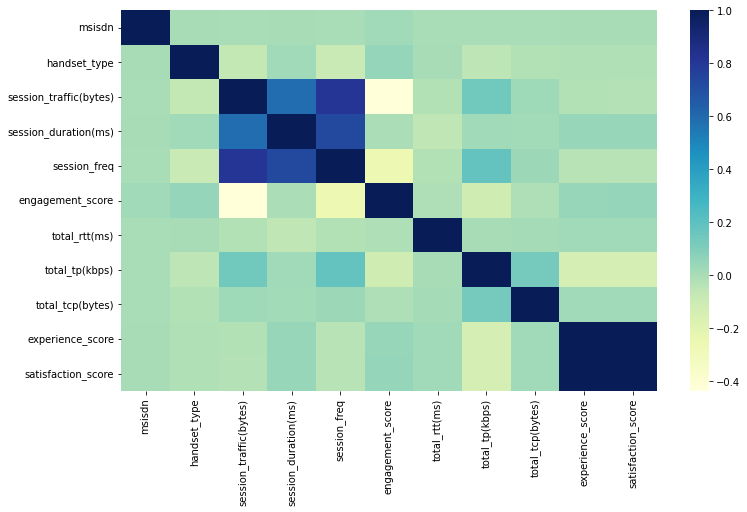

In [19]:
plt.figure(figsize=(12, 7))
sns.heatmap(label_encoded_satisfaction_metrics.corr(),cmap="YlGnBu")
plt.show()

Build Our Model

In [22]:
# Get X and Y values for the regression model
# X = label_encoded_satisfaction_metrics.loc[:,label_encoded_satisfaction_metrics.columns!="satisfaction_score" ]
# X = label_encoded_satisfaction_metrics[label_encoded_satisfaction_metrics.columns.difference(['satisfaction_score','handset_type','experience_score','engagement_score'])]
X = label_encoded_satisfaction_metrics[label_encoded_satisfaction_metrics.columns.difference(['satisfaction_score','handset_type'])]
Y = label_encoded_satisfaction_metrics['satisfaction_score']

scaler=StandardScaler()
X_data=scaler.fit_transform(X)
y_data=Y.to_numpy()

# Split inpute data into train and test

x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=10)

reg = LinearRegression()

model = reg.fit(x_train, y_train)
pred = model.predict(x_test)

In [25]:
# model.score(x_test,y_test)
pred

array([0.21972719, 0.08818814, 0.23230432, ..., 0.23644933, 0.23640657,
       0.23643858])